## Loading of Steinmetz data

includes some visualizations

In [1]:
import numpy as np
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [2]:
!pip install git+https://github.com/lindermanlab/ssm.git
import ssm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lindermanlab/ssm.git to /tmp/pip-req-build-d3jthyyr
  Running command git clone -q https://github.com/lindermanlab/ssm.git /tmp/pip-req-build-d3jthyyr
  Created wheel for ssm: filename=ssm-0.0.1-cp37-cp37m-linux_x86_64.whl size=402670 sha256=8791b28130b1c513e5f1e5d2346760d7168dcc9e547f9ecfb26ed290c17d64aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3pxrenr/wheels/c8/04/4e/bf90d9e04d0342f45dc1103b47678ce7e7ba1dbc97d431d254
Successfully built ssm


In [3]:
import autograd.numpy.random as npr
npr.seed(3)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


In [4]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [6]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

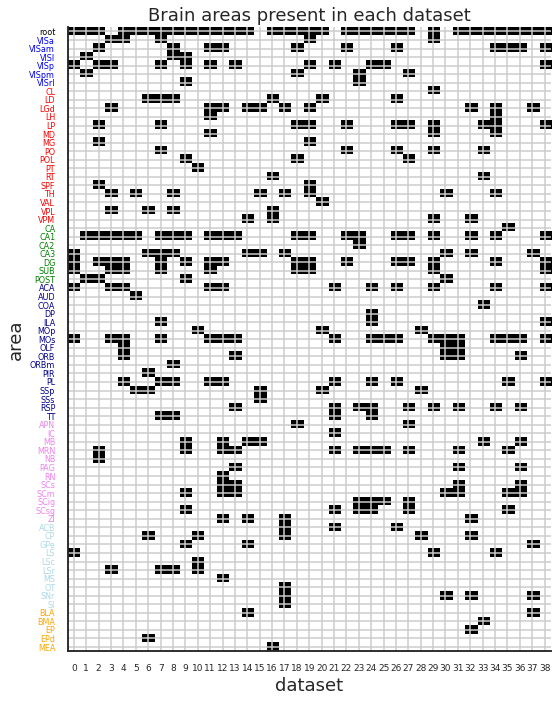

In [7]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [8]:
dat = alldat[11]   # a dict
brain_areas = dat['brain_area']
bin_size = dat['bin_size']
stim_onset = dat['stim_onset']
gocue = dat['gocue'] + stim_onset
feedback_time = dat['feedback_time'] + stim_onset
response_time = dat['response_time'] + stim_onset
neural_activity = dat['spks']

# stim_onset = int(stim_onset/bin_size)
# response_time = response_time/bin_size


In [9]:
nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

np.unique(barea, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([145, 155, 220,  78, 100]))

In [10]:
FR_vis = neural_activity[barea==0]
input = np.transpose(FR_vis,(1,0,2))
input_vis = np.mean(input, axis = 2)

In [23]:
input_vis.shape

(340, 145)

In [24]:
response = dat['response']
type(response)

numpy.ndarray

In [25]:
dat['contrast_right'].shape
dat['contrast_left'].shape
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
vis_stim = vis_left - vis_right # right - nogo - left

In [26]:
#right:-1, nogo:0, left:1
for i in np.arange(340):
  if vis_stim[i]<0:
    vis_stim[i] = -1
  if vis_stim[i]>0:
    vis_stim[i] = 1

In [27]:
vis_stim

array([ 0.,  0.,  0.,  1., -1.,  0., -1., -1.,  1., -1., -1., -1.,  1.,
        0.,  0.,  0.,  1.,  1.,  1.,  1., -1.,  1.,  0., -1., -1.,  0.,
        1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1., -1.,  1.,  0.,
        1., -1.,  0.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,
        0., -1., -1.,  1.,  1., -1., -1.,  1.,  0.,  0., -1.,  1.,  0.,
       -1., -1.,  0.,  0.,  1.,  1.,  1.,  0., -1.,  0.,  1.,  0.,  1.,
       -1.,  1.,  0.,  1.,  0.,  0.,  1., -1.,  0.,  0.,  1.,  1., -1.,
        0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0., -1., -1., -1.,  1.,
        1.,  0.,  0.,  1.,  1.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1., -1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,
       -1.,  1.,  1.,  0.,  0., -1., -1.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,
       -1.,  1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0

# Decoding stimulus from spiking in visual cortex

In [28]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
nKfold = 10
kf = KFold(n_splits=nKfold, shuffle=True, random_state=42)
acc = []
for train_index, test_index in kf.split(input_vis, vis_stim):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = input_vis[train_index], input_vis[test_index]
    y_train, y_test = vis_stim[train_index], vis_stim[test_index]
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = np.sum(y_pred==y_test)/len(y_test)
    print(accuracy)
    acc.append(accuracy)
print("prediction accuracy:",np.mean(acc))

TRAIN: [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36  37
  38  40  41  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95
  96  97  98  99 100 101 102 103 105 106 107 110 111 112 114 115 117 120
 121 122 123 125 127 128 129 130 131 132 133 134 135 136 137 138 140 141
 142 143 145 146 147 148 149 150 151 152 153 154 156 157 158 159 160 161
 162 163 164 166 167 168 169 170 171 173 174 175 177 178 179 180 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 211 212 213 214 215 216 217 218 219 220
 222 223 224 225 226 227 228 229 230 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 262 263 264 265 267 268 269 270 271

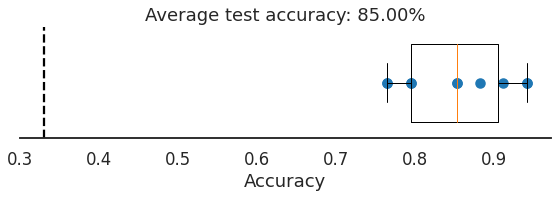

In [29]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(acc, vert=False, widths=.7)
ax.scatter(acc, np.ones(10))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {np.mean(acc):.2%}"
)
#plt.xlim(0.33, 0.5)
ax.spines["left"].set_visible(False)
ax.vlines(0.33,*ax.get_ylim(),ls='--',color='k')

# Decoing response from spiking in visual cortex

In [30]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
nKfold = 10
kf = KFold(n_splits=nKfold, shuffle=True, random_state=42)
acc = []
for train_index, test_index in kf.split(input_vis, response):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = input_vis[train_index], input_vis[test_index]
    y_train, y_test = response[train_index], response[test_index]
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = np.sum(y_pred==y_test)/len(y_test)
    print(accuracy)
    acc.append(accuracy)
print("prediction accuracy:",np.mean(acc))

TRAIN: [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36  37
  38  40  41  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95
  96  97  98  99 100 101 102 103 105 106 107 110 111 112 114 115 117 120
 121 122 123 125 127 128 129 130 131 132 133 134 135 136 137 138 140 141
 142 143 145 146 147 148 149 150 151 152 153 154 156 157 158 159 160 161
 162 163 164 166 167 168 169 170 171 173 174 175 177 178 179 180 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 211 212 213 214 215 216 217 218 219 220
 222 223 224 225 226 227 228 229 230 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 262 263 264 265 267 268 269 270 271

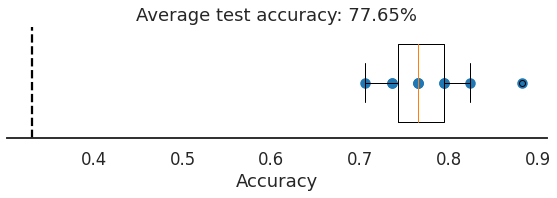

In [31]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(acc, vert=False, widths=.7)
ax.scatter(acc, np.ones(10))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {np.mean(acc):.2%}"
)
#plt.xlim(0.33, 0.5)
ax.spines["left"].set_visible(False)
ax.vlines(0.33,*ax.get_ylim(),ls='--',color='k')

# Decoding stimulus from spiking in mortor cortex

In [35]:
FR_mortor = neural_activity[barea==3]
input = np.transpose(FR_mortor,(1,0,2))
input_mor = np.mean(input, axis = 2)

In [36]:
input_mor.shape

(340, 78)

In [38]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
nKfold = 10
kf = KFold(n_splits=nKfold, shuffle=True, random_state=42)
acc = []
for train_index, test_index in kf.split(input_mor, vis_stim):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = input_mor[train_index], input_mor[test_index]
    y_train, y_test = vis_stim[train_index], vis_stim[test_index]
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = np.sum(y_pred==y_test)/len(y_test)
    print(accuracy)
    acc.append(accuracy)
print("prediction accuracy:",np.mean(acc))

TRAIN: [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36  37
  38  40  41  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95
  96  97  98  99 100 101 102 103 105 106 107 110 111 112 114 115 117 120
 121 122 123 125 127 128 129 130 131 132 133 134 135 136 137 138 140 141
 142 143 145 146 147 148 149 150 151 152 153 154 156 157 158 159 160 161
 162 163 164 166 167 168 169 170 171 173 174 175 177 178 179 180 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 211 212 213 214 215 216 217 218 219 220
 222 223 224 225 226 227 228 229 230 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 262 263 264 265 267 268 269 270 271

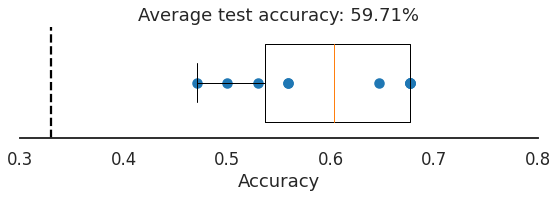

In [39]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(acc, vert=False, widths=.7)
ax.scatter(acc, np.ones(10))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {np.mean(acc):.2%}"
)
plt.xlim(0.3, 0.8)
ax.spines["left"].set_visible(False)
ax.vlines(0.33,*ax.get_ylim(),ls='--',color='k')

# Decoding response from spiking in mortor cortex

In [40]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
nKfold = 10
kf = KFold(n_splits=nKfold, shuffle=True, random_state=42)
acc = []
for train_index, test_index in kf.split(input_mor, response):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = input_mor[train_index], input_mor[test_index]
    y_train, y_test = response[train_index], response[test_index]
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = np.sum(y_pred==y_test)/len(y_test)
    print(accuracy)
    acc.append(accuracy)
print("prediction accuracy:",np.mean(acc))

TRAIN: [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36  37
  38  40  41  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95
  96  97  98  99 100 101 102 103 105 106 107 110 111 112 114 115 117 120
 121 122 123 125 127 128 129 130 131 132 133 134 135 136 137 138 140 141
 142 143 145 146 147 148 149 150 151 152 153 154 156 157 158 159 160 161
 162 163 164 166 167 168 169 170 171 173 174 175 177 178 179 180 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 211 212 213 214 215 216 217 218 219 220
 222 223 224 225 226 227 228 229 230 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 262 263 264 265 267 268 269 270 271

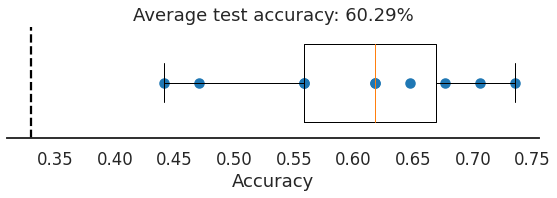

In [41]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(acc, vert=False, widths=.7)
ax.scatter(acc, np.ones(10))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {np.mean(acc):.2%}"
)
#plt.xlim(0.33, 0.5)
ax.spines["left"].set_visible(False)
ax.vlines(0.33,*ax.get_ylim(),ls='--',color='k')

# cross validation by trials

In [ ]:
def format_spikes(neural_activity, idx):
    datas = []
    for i in range(idx):
        spikes_cur = np.squeeze(neural_activity[:,:,i])

        
        # Transpose the data for passing to SSM fit function
        # To use the Poisson observation model, we must also
        # convert our arrays to be integer types.
        datas.append(np.asarray(spikes_cur.T,dtype=int))
    return datas

In [ ]:
datas = format_spikes(FR, 214)
N_iters = 50
obs_dim = FR.shape[0]
num_states = 3
from sklearn.model_selection import KFold
true_hmm = ssm.HMM(num_states, obs_dim, observations="poisson")
##===== K-fold Cross-Validation =====##
#There's no avoiding it! 

#Generate more data for cross-validation
trails = FR.shape[2]
true_states, datas = true_hmm.sample(trails)

#Create kfold cross-validation object which will split data for us
nKfold = 5
kf = KFold(n_splits=nKfold, shuffle=True, random_state=None)

#Just for sanity's sake, let's check how it splits the data
#So 5-fold cross-validation uses 80% of the data to train the model, and holds 20% for testing
for ii, (train_index, test_index) in enumerate(kf.split(datas)):
    print(f"kfold {ii} TRAIN:", len(train_index), "TEST:", len(test_index))

#10 different nnumber of latent states
#5-fold cross-validation
#That's 50 model fits! Thankfully this can be parallelized fairly easily
max_states = 10
ll_training = np.zeros((max_states,nKfold))
ll_heldout = np.zeros((max_states,nKfold))
BIC_heldout = np.zeros((max_states,nKfold))

hmm_z_ms = np.zeros((max_states,trails))

#Outer loop over the parameter for which you're doing model selection for
for iS, num_states in enumerate(range(1,max_states+1)):
    #Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
    K = num_states*num_states + num_states*obs_dim + num_states*obs_dim
    
    #Inner loop over kfolds
    for iK, (train_index, test_index) in enumerate(kf.split(datas)):
        nTrain = len(train_index); nTest = len(test_index)#*obs_dim
        
        #Split data
        training_data = datas[train_index]
        test_data = datas[test_index]
        
        #Create HMM object to fit
        hmm = ssm.HMM(num_states, obs_dim, observations="poisson")

        #fit on training data
        hmm_lls = hmm.fit(training_data, method="em", num_iters=N_iters)#, init_method="kmeans")
        
        #Compute log-likelihood for each dataset
        ll_training[iS,iK] = hmm.log_probability(training_data)/nTrain
        ll_heldout[iS,iK] = hmm.log_probability(test_data)/nTest
        
        #Let's calculate the BIC as well for this
        BIC_heldout[iS,iK] = K*np.log(nTest) - 2*hmm.log_probability(test_data)
        
    #Let's do a full model fit and get the state-sequence
    hmm = ssm.HMM(num_states, obs_dim, observations="poisson")
    hmm_lls = hmm.fit(datas, method="em", num_iters=N_iters)
    most_likely_states = hmm.most_likely_states(datas)
    
    hmm_z_ms[iS,:] = hmm.most_likely_states(datas)

kfold 0 TRAIN: 171 TEST: 43
kfold 1 TRAIN: 171 TEST: 43
kfold 2 TRAIN: 171 TEST: 43
kfold 3 TRAIN: 171 TEST: 43
kfold 4 TRAIN: 172 TEST: 42


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
hmm

In [ ]:
len(hmm_lls)

51

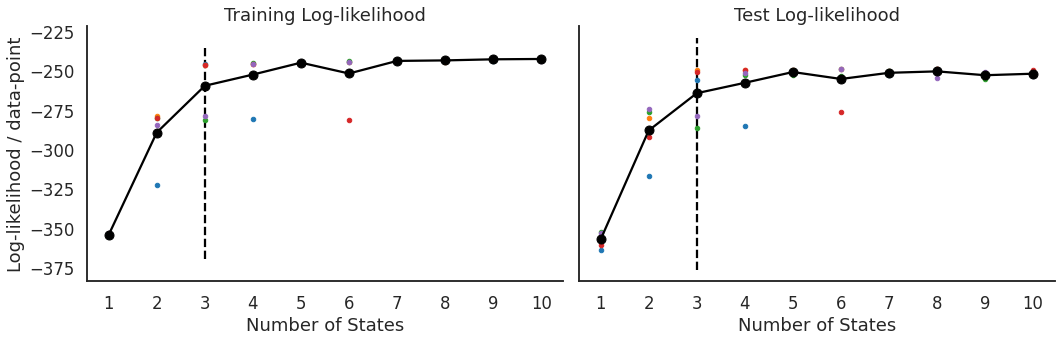

In [ ]:
##===== Let's plot the heldout and training log-likelihoods and compare =====##
fig, axes = plt.subplots(1,2,figsize=(15,5),sharey=True)

#Training data
axes[0].plot(np.arange(1,11),ll_training,'.')
axes[0].plot(np.arange(1,11),np.mean(ll_training,axis=1),'-ok')
axes[0].set_title('Training Log-likelihood')
axes[0].set_ylabel('Log-likelihood / data-point')

axes[1].plot(np.arange(1,11),ll_heldout,'.')
axes[1].plot(np.arange(1,11),np.mean(ll_heldout,axis=1),'-ok')
axes[1].set_title('Test Log-likelihood')

for ax in axes:
    ax.set_xticks(np.arange(1,11))
    ax.set_xlabel('Number of States')
    ax.vlines(3,*ax.get_ylim(),ls='--',color='k')

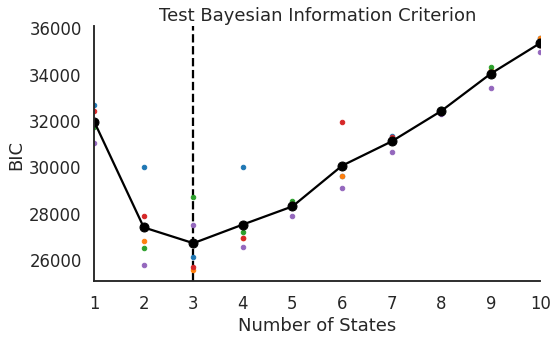

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.arange(1,11),BIC_heldout,'.')
ax.plot(np.arange(1,11),np.mean(BIC_heldout,axis=1),'-ok')
ax.set_title('Test Bayesian Information Criterion')

ax.set_xticks(np.arange(1,11))
ax.set_xlabel('Number of States')
ax.set_ylabel('BIC')
ax.vlines(3,*ax.get_ylim(),ls='--',color='k')
ax.autoscale(tight=True)